In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("ccdefault.csv").drop(columns=["ID"])

In [3]:
data.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
data.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'DEFAULT'],
      dtype='object')

In [5]:
data.shape

(30000, 24)

# Part 1: Random Forest Estimators

In [6]:
# Split dataset for traning and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=["DEFAULT"]), data["DEFAULT"], test_size = 0.1, random_state = 1)

In [7]:
# Conduct grid search and cross validation on traning set
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


# input data is training set
def cross_val(X, y, metric):
    param_grid = {
        'n_estimators': [100, 200, 300],
    }

    # Define knn model
    rf = RandomForestClassifier()

    cv = 3

    grid_search = GridSearchCV(rf, param_grid, cv=cv, n_jobs=-1,  scoring=metric)
    grid_search.fit(X, y)
    print("Best parameter setting: %s" % grid_search.best_params_)
    print("Best cross-validation " + metric +  " score: %0.4f" % grid_search.best_score_)
    
    cv_results = grid_search.cv_results_


    for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
        print(mean_score, params)

In [8]:
cross_val(X_train, y_train, "accuracy")

Best parameter setting: {'n_estimators': 300}
Best cross-validation accuracy score: 0.8162
0.8150740740740741 {'n_estimators': 100}
0.8157407407407408 {'n_estimators': 200}
0.8162222222222222 {'n_estimators': 300}


# Part 2: Random Forest Feature Importance

In [9]:
# Fit the model with the best parameters
rf = RandomForestClassifier(n_estimators=300)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=300)

In [10]:
# Display the feature importance of the random forest model
indices = np.argsort(rf.feature_importances_)[::-1]

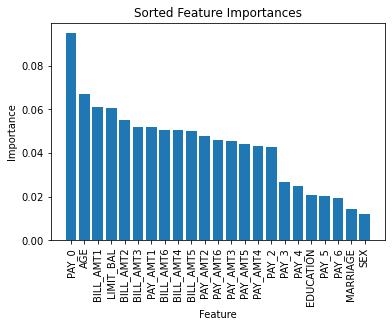

In [11]:
plt.figure()
plt.bar(X_train.columns[indices], rf.feature_importances_[indices])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Sorted Feature Importances')
plt.show()

In [12]:
dict(zip(X_train.columns[indices], np.round(rf.feature_importances_[indices], 4)))

{'PAY_0': 0.0948,
 'AGE': 0.0668,
 'BILL_AMT1': 0.0608,
 'LIMIT_BAL': 0.0604,
 'BILL_AMT2': 0.0551,
 'BILL_AMT3': 0.0519,
 'PAY_AMT1': 0.0517,
 'BILL_AMT6': 0.0506,
 'BILL_AMT4': 0.0504,
 'BILL_AMT5': 0.0501,
 'PAY_AMT2': 0.0478,
 'PAY_AMT6': 0.0461,
 'PAY_AMT3': 0.0455,
 'PAY_AMT5': 0.0439,
 'PAY_AMT4': 0.043,
 'PAY_2': 0.0428,
 'PAY_3': 0.0265,
 'PAY_4': 0.0247,
 'EDUCATION': 0.0209,
 'PAY_5': 0.0203,
 'PAY_6': 0.0196,
 'MARRIAGE': 0.0141,
 'SEX': 0.0122}

In [13]:
accuracy_score(rf.predict(X_test), y_test)

0.8176666666666667

# Conclusion
First from the test accuracy is 0.817 which is even higher than the cross validation average accuracy. It indicates that our model is not overfitting. We could probably increase the maximum depth or number of subtrees in the future model tuining. <br>
a) n_estimators is positively correlative to CV accuracy and computation time. <br>
b) The optimal number of estmator is 300. <br>
c) PAY_0 contributes the most importance. <br>
d) Since random forest is a little bit black-box, we can specifically see the causality of each features. The, we can only inspect how much a feature contribute to the impurity reduction of nodes. The impurity is calculated by some metrics for example entropy, etc. The feature importance score for a particular feature is calculated as the sum of the decrease in impurity over all node.